# Experimenting with adding time-varying metallicity into a single SFH component, with just a 2-step metallicity for now
I looked through bagpipes' chemical_enrichment_history.py file and roughly have an idea about how this can be done...

In [1]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from PyAstronomy import pyasl
import seaborn as sns
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
from scipy.optimize import curve_fit

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


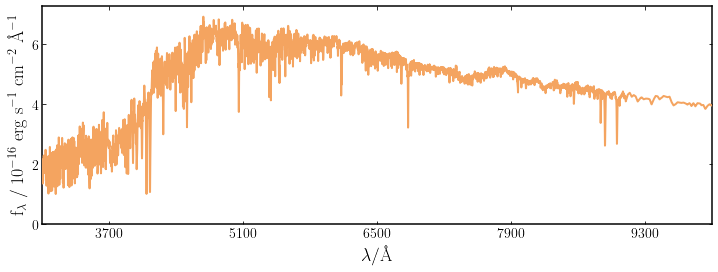

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [3]:
# creating toy bagpipes models to extract inputs into chemical_enrichment_history.__init__ for later testing
# purposes
psb = {}
psb['massformed'] = 10
psb['metallicity'] = 1.0
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 250
psb['beta'] = 250
psb['fburst'] = 0.2

model_components = {}
model_components['psb_wild2020'] = psb
model_components['redshift'] = 0.04

obs_wavs = np.arange(3000., 10000., 1.)
pre_change_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
pre_change_model.plot()

In [109]:
# adding a new function to chemical_enrichment_history.py
import bagpipes.config as config

def __init__(self, model_comp, sfh_weights):

    self.zmet_vals = config.metallicities
    self.zmet_lims = config.metallicity_bins

    self.grid_comp = {}
    self.grid = np.zeros((self.zmet_vals.shape[0],
                          config.age_sampling.shape[0]))

    for comp in list(sfh_weights):
        if comp is not "total":
            self.grid_comp[comp] = self.psb_two_step(model_comp[comp],
                                              sfh_weights[comp])

            self.grid += self.grid_comp[comp]
    global grid_comp 
    grid_comp = self.grid

def delta_(self, zmet):
    weights = np.zeros(self.zmet_vals.shape[0])

    high_ind = self.zmet_vals[self.zmet_vals < zmet].shape[0]

    if high_ind == self.zmet_vals.shape[0]:
        weights[-1] = 1.

    elif high_ind == 0:
        weights[0] = 1.

    else:
        low_ind = high_ind - 1
        width = (self.zmet_vals[high_ind] - self.zmet_vals[low_ind])
        weights[high_ind] = (zmet - self.zmet_vals[low_ind])/width
        weights[high_ind-1] = 1 - weights[high_ind]
        
    return weights

def psb_two_step(self, comp, sfh):
    """ 2-step metallicities (time-varying!) for psb SFH shape, shift at burstage """
    
    zmet_old = comp["metallicity_old"]
    zmet_burst = comp["metallicity_burst"]
    burstage = comp["burstage"]*10**9
    
    # get SSP ages
    SSP_ages = config.age_sampling
    SSP_age_bins = config.age_bins
    
    # loop through all SSP ages
    zmet_comp = np.zeros((self.zmet_vals.shape[0], sfh.shape[0]))
    for i,agei in enumerate(SSP_ages):
        # detect if the SSP age's higher boundary > tburst and lower boundary < tburst
        if SSP_age_bins[i+1]>burstage and SSP_age_bins[i]<burstage:
            # interp between to get metallicity at this SSP
            width = SSP_age_bins[i+1] - SSP_age_bins[i]
            old_weight = (SSP_age_bins[i+1] - burstage)/width
            burst_weight = (burstage - SSP_age_bins[i])/width
            SSP_zmet = old_weight*zmet_old + burst_weight*zmet_burst
            # interp metallicity (delta-style) to get weights with the interped metallicity
            zmet_comp[:,i] = self.delta_(SSP_zmet)
        
        # if before tburst
        elif SSP_age_bins[i]>burstage:
            # interp metallicity (delta-style) to get weights with the earlier metallicity
            zmet_comp[:,i] = self.delta_(zmet_old)
            
        # if after tburst
        elif SSP_age_bins[i+1]<burstage:
            # interp metallicity (delta-style) to get weights with the starburst metallicity
            zmet_comp[:,i] = self.delta_(zmet_burst)
            
        else:
            print('help')
    
    #print(zmet_comp)
    return zmet_comp*np.expand_dims(sfh, axis=0)
    
pipes.models.chemical_enrichment_history.__init__ = __init__
pipes.models.chemical_enrichment_history.delta_ = delta_
pipes.models.chemical_enrichment_history.psb_two_step = psb_two_step
    

In [110]:
psb = {}
psb['massformed'] = 10
psb['metallicity_old'] = 1.0
psb['metallicity_burst'] = 2.0
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 250
psb['beta'] = 250
psb['fburst'] = 0.2

model_components = {}
model_components['psb_wild2020'] = psb
model_components['redshift'] = 0.04

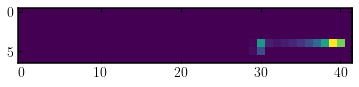

In [111]:
pipes.models.chemical_enrichment_history(model_components, pre_change_model.sfh.component_weights)
plt.imshow(grid_comp)

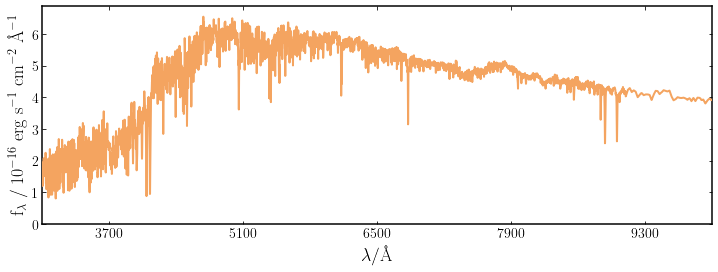

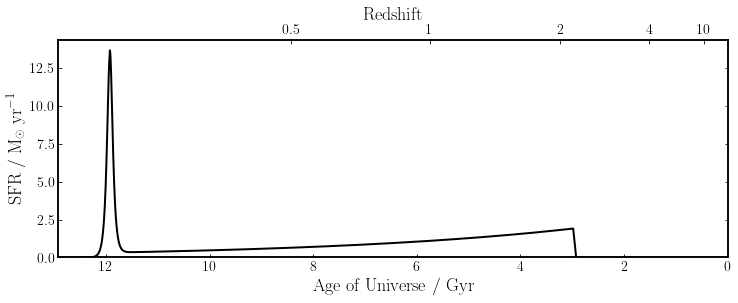

(<Figure size 864x288 with 2 Axes>,
 <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>)

In [115]:
post_change_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
post_change_model.plot()
post_change_model.sfh.plot()

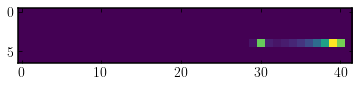

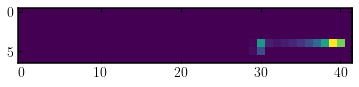

In [113]:
plt.imshow(pre_change_model.sfh.ceh.grid)
plt.show()
plt.imshow(post_change_model.sfh.ceh.grid)
plt.show()

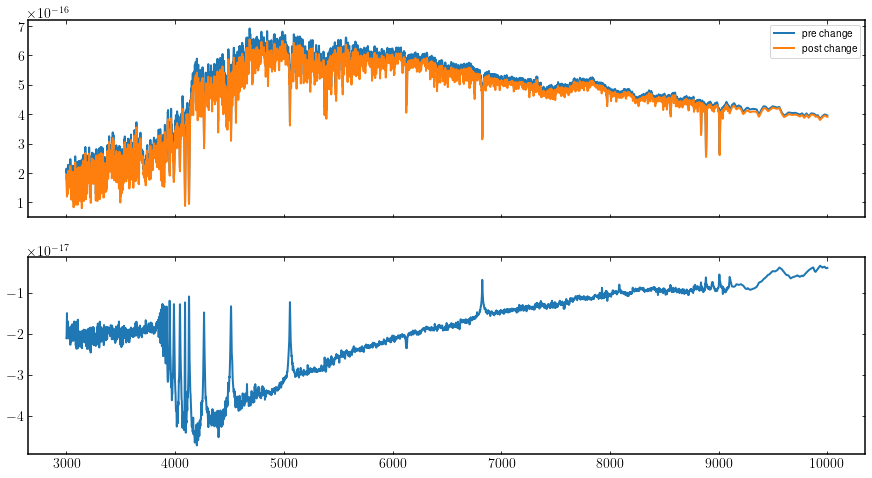

In [114]:
fig, ax = plt.subplots(2,1, figsize=[15,8], sharex=True)
ax[0].plot(obs_wavs, pre_change_model.spectrum[:,1], label='pre change')
ax[0].plot(obs_wavs, post_change_model.spectrum[:,1], label='post change')
ax[0].legend()
ax[1].plot(obs_wavs, post_change_model.spectrum[:,1] - pre_change_model.spectrum[:,1])
plt.show()

## edit seems successful, now proceed to fit this post_change_model with bagpipes

In [172]:
def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    ind = np.where(wave<3000)
    mask.extend(ind[0])    

    return mask

def load_uds_spectrum_mask_generated(ID,z):

    # load spectral data
    spectrum = post_change_model.spectrum.copy()
    spectrum_noise = spectrum[:,1]/15
    spectrum = np.hstack([spectrum, np.expand_dims(spectrum_noise, axis=1)])

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum
    

def load_uds_mask_generated(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask_generated(ID,z)

    return spectrum

def get_fit_instructions(z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb2 = {}
    psb2["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb2["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
    psb2["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
    psb2["metallicity_old"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
    psb2["metallicity_old_prior"] = "log_10"
    psb2["metallicity_burst"] = (0.01, 2.5)
    psb2["metallicity_burst_prior"] = "log_10"
    
    psb2["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
    psb2["alpha"] = (0.01,1000)               # decline of burst
    psb2["alpha_prior"] = "log_10"
    psb2["beta"] = 250.                    # rise of burst: fixed
    psb2["fburst"] = (0,1)
    
    fit_instructions = {}
    fit_instructions['psb_wild2020'] = psb2
    fit_instructions['redshift'] = (z-0.2*z, z+0.2*z)
    
    return fit_instructions

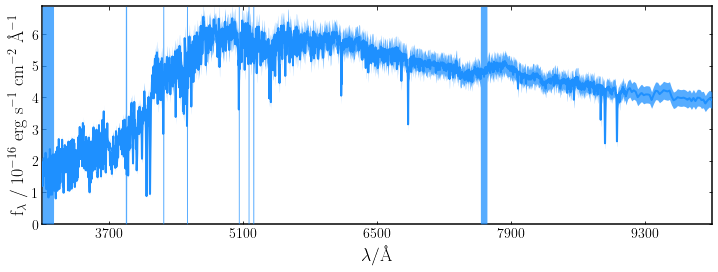

In [175]:
ID = 'two_step_metallicity_generated_psb_no_dust_no_noise_SNR15_recovary_test'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask_generated, photometry_exists=False)

fig = galaxy.plot()

In [176]:
fit_instructions = get_fit_instructions()
print(fit_instructions)

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10', 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [129]:
pipes.config.Rspec = 4340
runID = "two_step_metallicity_generated_psb_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object two_step_metallicity_generated_psb_no_dust_no_noise_SNR15_recovary_test


Completed in 3026.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               7.545      9.561     11.413
psb_wild2020:alpha           211.497    399.302    716.045
psb_wild2020:burstage          0.946      0.992      1.043
psb_wild2020:fburst            0.189      0.205      0.225
psb_wild2020:massformed        9.953      9.984     10.008
psb_wild2020:metallicity_burst      1.564      1.848      2.179
psb_wild2020:metallicity_old      1.018      1.142      1.324
psb_wild2020:tau               3.506      6.524      8.820
redshift                       0.040      0.040      0.040




In [202]:
def plot_spec(fit, ID, runID):

    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    fit.posterior.get_advanced_quantities()

    naxes=1
    fig = plt.figure(figsize=(12, 5.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1)
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)

    post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(fit.galaxy.spectrum[:,0],(post_median - fit.galaxy.spectrum[:,1])*10**-y_scale, color="sandybrown")
    #ax1.set_xlim([3000,4200])
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax3.set_ylabel('residual')
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
    plt.show()

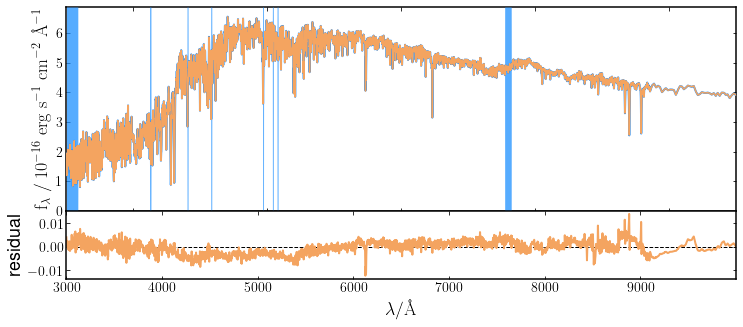

In [130]:
plot_spec(fit, ID, runID)

In [163]:
pipes.plotting.general.latex_names['burstage'] = '\\mathrm{Burst\\ Age}'
pipes.plotting.general.latex_units['burstage'] = "\\mathrm{Gyr}"

pipes.plotting.general.latex_names['fburst'] = '\\mathrm{f_{burst}}'

pipes.plotting.general.latex_names['metallicity_old'] = '\\mathrm{Z_{old}}'
pipes.plotting.general.latex_units['metallicity_old'] = "Z_{\\odot}"

pipes.plotting.general.latex_names['metallicity_burst'] = '\\mathrm{Z_{burst}}'
pipes.plotting.general.latex_units['metallicity_burst'] = "Z_{\\odot}"

pipes.plotting.general.latex_comps['psb_wild2020'] = 'PSB'

fig = fit.plot_corner(save=True, show=True)

In [178]:
def integrate_sfh(ages, sfh, Mstar=None):
    """ 
    takes a sfh and integrates it to return a cumulative SFH (normalized to run from 0 to 1) fraction of 
    mass formed
    """
    if Mstar is None:
        Mstar = np.trapz(y=sfh,x=ages)
    c_sfh = np.zeros(len(sfh))
    for i,sfhi in enumerate(sfh):
        c_sfh[i] = np.trapz(sfh[:i+1],x=ages[:i+1]/Mstar)
    return c_sfh

# extracted from bagpipes.models.star_formation_history.py, with a bit of tweaking
def psb_wild2020(age_list, age, tau, burstage, alpha, beta, fburst, Mstar):
    """
    A 2-component SFH for post-starburst galaxies. An exponential
    compoent represents the existing stellar population before the
    starburst, while a double power law makes up the burst.
    The weight of mass formed between the two is controlled by a
    fburst factor: thefraction of mass formed in the burst.
    For more detail, see Wild et al. 2020
    (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494..529W/abstract)
    """
    age_lhs = pipes.utils.make_bins(np.log10(age_list)+9, make_rhs=True)[0]
    age_list = age_list*10**9
    age_lhs = 10**age_lhs
    age_lhs[0] = 0.
    age_lhs[-1] = 10**9*pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    age_widths = age_lhs[1:] - age_lhs[:-1]
    sfr = np.zeros(len(age_list))
    
    age_of_universe = 10**9*np.interp(0, pipes.utils.z_array,
                                               pipes.utils.age_at_z)
    
    age = age*10**9
    tau = tau*10**9
    burstage = burstage*10**9

    ind = (np.where((age_list < age) & (age_list > burstage)))[0]
    texp = age - age_list[ind]
    sfr_exp = np.exp(-texp/tau)
    sfr_exp_tot = np.sum(sfr_exp*age_widths[ind])

    mask = age_list < age_of_universe
    tburst = age_of_universe - age_list[mask]
    tau_plaw = age_of_universe - burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*age_widths[mask])

    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot

    dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr[mask] += fburst * dpl_form / sfr_burst_tot
    
    return sfr*10**Mstar

def fit_f_burst(ages, sfh, age_at_z):
    # using scipy curve fit to get a fit to the true SFH
    popt,pcov = curve_fit(psb_wild2020, ages, sfh, 
                          bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))
    [age, tau, burstage, alpha, beta, fburst, Mstar] = popt
    tform = age_at_z - age
    tburst = age_at_z - burstage
    return fburst, tburst, tform, alpha, beta

def plot_sfh(fit, model_lookbacktime, model_sfh, ID, runID, model_f_burst=None, model_burstage=None):
    """
    Plots the regular SFH (SFR vs age of universe) plot on the top, cumulative SFH plot on the bottom
    """
    if 'redshift' in fit.posterior.samples.keys():
        post_z = np.median(fit.posterior.samples['redshift'])
    else: post_z = 0.04
    age_at_z = pipes.utils.cosmo.age(post_z).value

    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    median_sfh = np.median(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_ages_int = post_ages.copy()[::-1]*10**9
    post_m_total = np.trapz(y=median_sfh[::-1], x=post_ages_int)
    # integrate to get cumulative median
    c_median_sfh = integrate_sfh(post_ages_int, median_sfh[::-1], Mstar=post_m_total)

    #model sfh
    model_sfh = model_sfh.copy()
    model_ages = age_at_z-model_lookbacktime.copy()
    model_ages_int = model_ages.copy()[::-1]*10**9
    model_m_total = np.trapz(y=model_sfh[::-1], x=model_ages_int)
    # integrate to get cumulative of model sfh
    c_model_sfh = integrate_sfh(model_ages_int, model_sfh[::-1], Mstar=model_m_total)
    
    print('only recovered',post_m_total/model_m_total,'of total mass formed.')
    print(np.log10(post_m_total), np.log10(model_m_total))

    #calculating posterior tx and their uncertainties
    mass_percentiles = np.linspace(0,1,5)[1:-1]
    txs = []
    c_sfh_samples = []
    for sfh_sample in fit.posterior.samples['sfh']:
        sfh_ = sfh_sample[::-1]
        c_sfh_ = integrate_sfh(post_ages_int, sfh_)
        c_sfh_samples.append(c_sfh_)
        txs.append(np.interp(mass_percentiles, c_sfh_, post_ages_int))
    txs = (np.array(txs)/10**9).T
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    #print(tx_percentiles)
    c_sfh_percentiles = np.percentile(c_sfh_samples, (16,50,84), axis=0)
    
    ################# plotting 
    
    fig, ax = plt.subplots(2,1, figsize=[15,10])
    pipes.plotting.add_sfh_posterior(fit, ax[0], z_axis=False)
    ax[0].plot(model_ages, model_sfh)
    ylim = ax[0].get_ylim()

    #calculate model burst fraction
    if model_f_burst is None and model_burstage is None:
        model_f_burst, model_t_burst, model_t_form, model_alpha, model_beta = fit_f_burst(
            model_lookbacktime.copy(), model_sfh, age_at_z)
    else:
        model_t_burst = age_at_z - model_burstage
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    ax[0].vlines(model_t_burst, 0, ylim[1], color='red', ls='--')
    ax[0].arrow(age_at_z,ylim[1]*0.8,-(age_at_z-model_t_burst),0.0,color='red',head_width=np.max(ylim)/20., 
             head_length=0.1,length_includes_head=True)

    #use psb2's built in fburst and tburst posteriors to plot arrows
    post_f_burst = np.percentile(fit.posterior.samples['psb_wild2020:fburst'], (16,50,84))
    post_t_burst = age_of_universe-np.percentile(fit.posterior.samples['psb_wild2020:burstage'], (84,50,16))

    print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
    ax[0].vlines(post_t_burst[1], 0, ylim[1], color='sandybrown', ls='--')
    ax[0].arrow(age_of_universe,ylim[1]*0.9,-(age_of_universe-post_t_burst[1]),0.0,color='sandybrown',
             head_width=np.max(ylim)/20., head_length=0.1,length_includes_head=True)

    #plot vertical bands of tx percentiles
    for i,[l,m,u] in enumerate(tx_percentiles):
        ax[0].vlines(m, 0, 10*ylim[1], color = 'k', ls='--', alpha=0.5)
        ax[0].fill_betweenx([0,10*ylim[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
    
    ax[0].set_ylim(ylim)
    #add text about z, age at z, poster f_burst and t_burst
    f_burst_r = [np.round(post_f_burst[1],2),np.round(post_f_burst[2]-post_f_burst[1],2),
                 np.round(post_f_burst[1]-post_f_burst[0],2)]
    f_burst_text = f'post f\_burst={f_burst_r[0]}+{f_burst_r[1]}-{f_burst_r[2]}\n '
    t_burst_r = [np.round(post_t_burst[1],2),np.round(post_t_burst[2]-post_t_burst[1],2),
                 np.round(post_t_burst[1]-post_t_burst[0],2)]
    t_burst_text = f'post t\_burst={t_burst_r[0]}+{t_burst_r[1]}-{t_burst_r[2]}Gyr \n '
    ax[0].text(0.03,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr\n ' + 
            f_burst_text + 
            f'true f\_burst={np.round(model_f_burst,2)}\n ' +
            t_burst_text +
            f'true t\_burst={np.round(model_t_burst,2)}Gyr',
            fontsize=14, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    pipes.plotting.add_z_axis(ax[0])
    
    ax[1].plot(model_ages[::-1], c_model_sfh, zorder=1)
    ax[1].plot(post_ages[::-1], c_sfh_percentiles[1], color='k', zorder=1)
    ax[1].fill_between(post_ages[::-1], c_sfh_percentiles[0], c_sfh_percentiles[2], color='gray', 
                       alpha=0.6, zorder=0)
    ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,5)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                        tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='red', label='calculated equivilent tx times (assuming 4 bins)', fmt='o', zorder=2)
    
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel(ax[0].get_xlabel())
    ax[1].set_ylabel('fraction of cumulative mass formed')
    
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
    return fig,ax

only recovered 0.8247816088591002 of total mass formed.
9.9163407672905 10.000001798889988
model f_burst and t_burst: 0.2 11.924068776721654
model f_burst and t_burst: 0.2 11.924068776721654
posterior f_burst and t_burst: [0.18933163 0.20466059 0.22499426] [11.88701211 11.9326204  11.97224114]


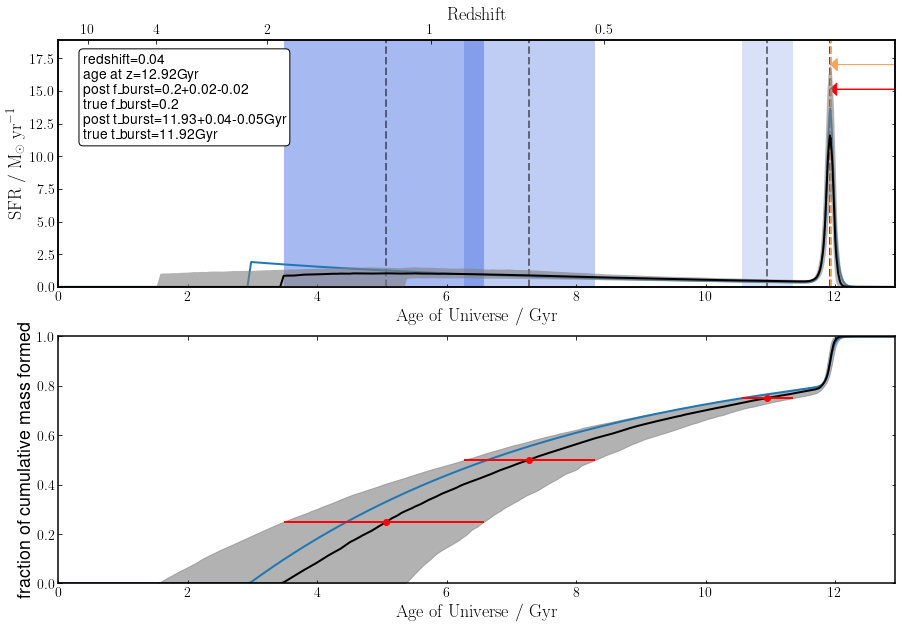

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [179]:
plot_sfh(fit, post_change_model.sfh.ages*10**-9, post_change_model.sfh.sfh, ID, runID, 
         model_f_burst=model_components['psb_wild2020']['fburst'], 
         model_burstage=model_components['psb_wild2020']['burstage'])

## This seems to work great, what about applying this on Yirui's simulated galaxy?

In [211]:
def load_uds_spectrum_mask(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname='../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                          ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum

def load_uds_mask(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask(ID,z)

    return spectrum

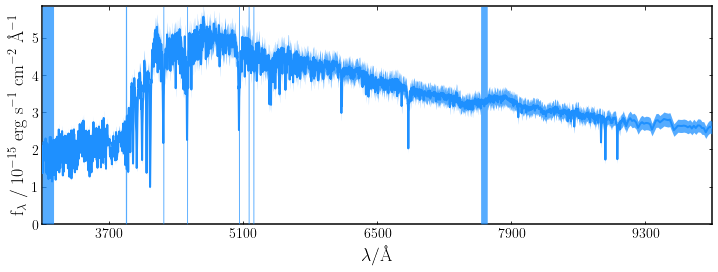

In [181]:
ID = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fig = galaxy.plot()

In [182]:
fit_instructions = get_fit_instructions()
print(fit_instructions)

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10', 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [146]:
pipes.config.Rspec = 4340
runID = "two_step_metallicity_yirui_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object 2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test


Completed in 19141.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               6.304      8.437     10.701
psb_wild2020:alpha           159.562    171.220    183.438
psb_wild2020:burstage          0.516      0.542      0.571
psb_wild2020:fburst            0.164      0.179      0.201
psb_wild2020:massformed       10.705     10.742     10.780
psb_wild2020:metallicity_burst      2.268      2.390      2.467
psb_wild2020:metallicity_old      1.194      1.390      1.591
psb_wild2020:tau               1.706      4.619      8.199
redshift                       0.040      0.040      0.040




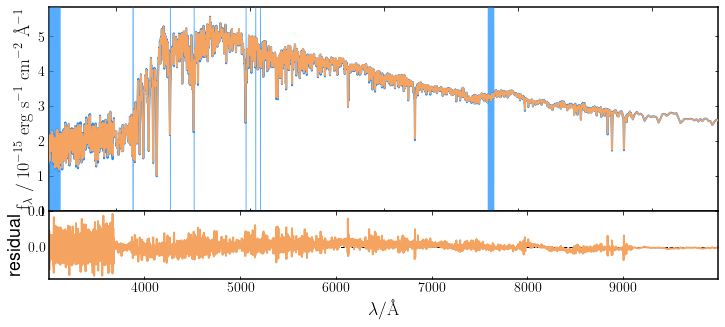

In [147]:
plot_spec(fit, ID, runID)

In [157]:
pipes.plotting.general.latex_names['burstage'] = '\\mathrm{Burst\\ Age}'
pipes.plotting.general.latex_units['burstage'] = "\\mathrm{Gyr}"

pipes.plotting.general.latex_names['fburst'] = '\\mathrm{f_{burst}}'

pipes.plotting.general.latex_names['metallicity_old'] = '\\mathrm{Z_{old}}'
pipes.plotting.general.latex_units['metallicity_old'] = "Z_{\\odot}"

pipes.plotting.general.latex_names['metallicity_burst'] = '\\mathrm{Z_{burst}}'
pipes.plotting.general.latex_units['metallicity_burst'] = "Z_{\\odot}"

pipes.plotting.general.latex_comps['psb_wild2020'] = 'PSB'

fig = fit.plot_corner(save=True, show=True)

In [184]:
age_at_z = pipes.utils.cosmo.age(0).value
sim_data = np.loadtxt('../../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()

only recovered 0.4141438071930079 of total mass formed.
10.643553351760389 11.026402180142501
model f_burst and t_burst: 0.08993122012854099 12.37406065609851
model f_burst and t_burst: 0.08993122012854099 12.37406065609851
posterior f_burst and t_burst: [0.16447544 0.17992025 0.20121266] [12.34921596 12.38070851 12.40923999]


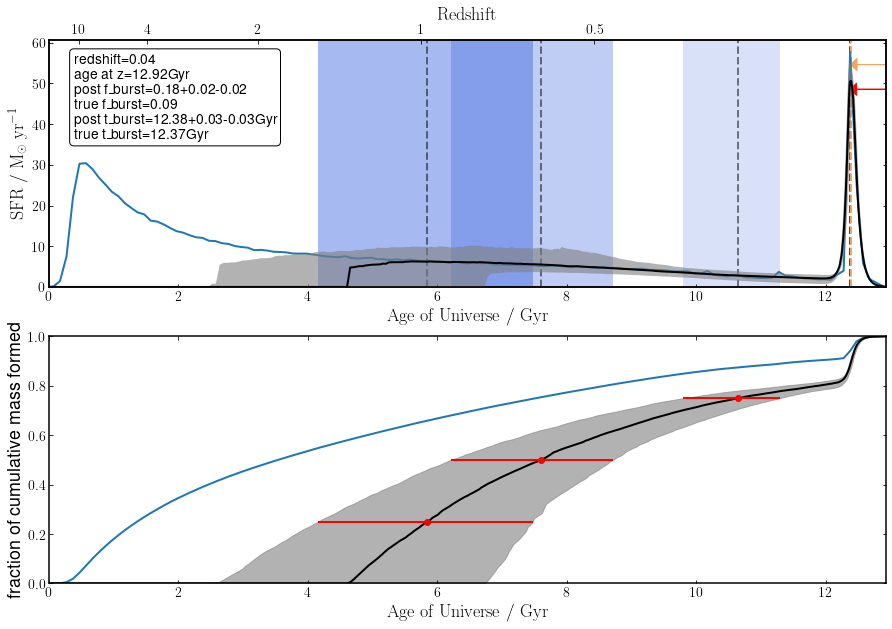

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [185]:
plot_sfh(fit, model_ages, model_sfh, ID, runID)

## Didn't seem to change much in terms of fixing outshining, maybe we throw in exp scatter as well?

In [186]:
def __init__(self, model_comp, sfh_weights):

    self.zmet_vals = config.metallicities
    self.zmet_lims = config.metallicity_bins

    self.grid_comp = {}
    self.grid = np.zeros((self.zmet_vals.shape[0],
                          config.age_sampling.shape[0]))

    for comp in list(sfh_weights):
        if comp is not "total":
            self.grid_comp[comp] = self.psb_two_step2(model_comp[comp],
                                              sfh_weights[comp])

            self.grid += self.grid_comp[comp]
    global grid_comp 
    grid_comp = self.grid

def delta_(self, zmet):
    weights = np.zeros(self.zmet_vals.shape[0])

    high_ind = self.zmet_vals[self.zmet_vals < zmet].shape[0]

    if high_ind == self.zmet_vals.shape[0]:
        weights[-1] = 1.

    elif high_ind == 0:
        weights[0] = 1.

    else:
        low_ind = high_ind - 1
        width = (self.zmet_vals[high_ind] - self.zmet_vals[low_ind])
        weights[high_ind] = (zmet - self.zmet_vals[low_ind])/width
        weights[high_ind-1] = 1 - weights[high_ind]
        
    return weights

def exp_(self, mean_zmet):
    """ P(Z) = exp(-z/z_mean). Currently no age dependency! """

    weights = np.zeros(self.zmet_vals.shape[0])

    vals_hr = np.arange(0., 10., 0.01) + 0.005

    factors_hr = (1./mean_zmet)*np.exp(-vals_hr/mean_zmet)

    for i in range(weights.shape[0]):
        lowmask = (vals_hr > self.zmet_lims[i])
        highmask = (vals_hr < self.zmet_lims[i+1])
        weights[i] = np.sum(0.01*factors_hr[lowmask & highmask])

    return weights

def psb_two_step2(self, comp, sfh):
    """ 2-step metallicities (time-varying!) for psb SFH shape, shift at burstage """
    
    zmet_old = comp["metallicity_old"]
    zmet_burst = comp["metallicity_burst"]
    burstage = comp["burstage"]*10**9
    if "metallicity_scatter" not in comp.keys():
        scatter_func = self.delta_
    else:
        if comp["metallicity_scatter"] == 'delta':
            scatter_func = self.delta_
        elif comp["metallicity_scatter"] == 'exponential':
            scatter_func = self.exp_
    
    # get SSP ages
    SSP_ages = config.age_sampling
    SSP_age_bins = config.age_bins
    
    # loop through all SSP ages
    zmet_comp = np.zeros((self.zmet_vals.shape[0], sfh.shape[0]))
    for i,agei in enumerate(SSP_ages):
        # detect if the SSP age's higher boundary > tburst and lower boundary < tburst
        if SSP_age_bins[i+1]>burstage and SSP_age_bins[i]<burstage:
            # interp between to get metallicity at this SSP
            width = SSP_age_bins[i+1] - SSP_age_bins[i]
            old_weight = (SSP_age_bins[i+1] - burstage)/width
            burst_weight = (burstage - SSP_age_bins[i])/width
            SSP_zmet = old_weight*zmet_old + burst_weight*zmet_burst
            # interp metallicity (delta-style) to get weights with the interped metallicity
            zmet_comp[:,i] = scatter_func(SSP_zmet)
        
        # if before tburst
        elif SSP_age_bins[i]>burstage:
            # interp metallicity (delta-style) to get weights with the earlier metallicity
            zmet_comp[:,i] = scatter_func(zmet_old)
            
        # if after tburst
        elif SSP_age_bins[i+1]<burstage:
            # interp metallicity (delta-style) to get weights with the starburst metallicity
            zmet_comp[:,i] = scatter_func(zmet_burst)
            
        else:
            print('help')
    
    #print(zmet_comp)
    return zmet_comp*np.expand_dims(sfh, axis=0)
    
pipes.models.chemical_enrichment_history.__init__ = __init__
pipes.models.chemical_enrichment_history.delta_ = delta_
pipes.models.chemical_enrichment_history.exp_ = exp_
pipes.models.chemical_enrichment_history.psb_two_step2 = psb_two_step2

In [187]:
psb = {}
psb['massformed'] = 10
psb['metallicity_old'] = 1.0
psb['metallicity_burst'] = 2.0
psb['metallicity_scatter'] = 'exponential'
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 250
psb['beta'] = 250
psb['fburst'] = 0.2

model_components2 = {}
model_components2['psb_wild2020'] = psb
model_components2['redshift'] = 0.04

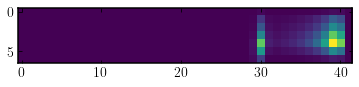

In [191]:
pipes.models.chemical_enrichment_history(model_components2, pre_change_model.sfh.component_weights)
plt.imshow(grid_comp)

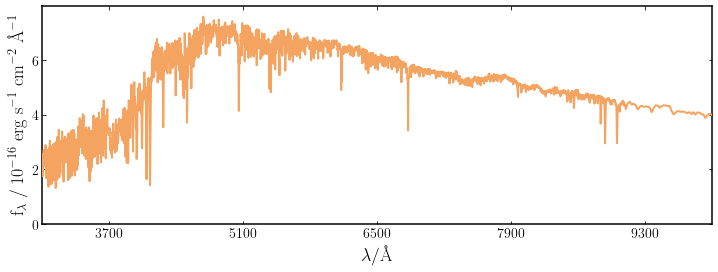

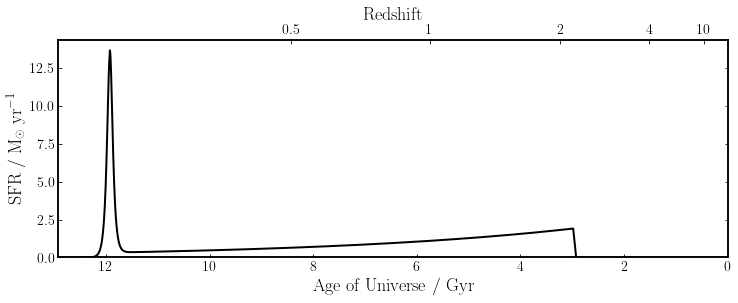

(<Figure size 864x288 with 2 Axes>,
 <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>)

In [192]:
twostep_exp_model = pipes.model_galaxy(model_components2, spec_wavs=obs_wavs)
twostep_exp_model.plot()
twostep_exp_model.sfh.plot()

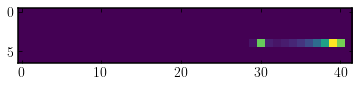

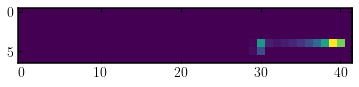

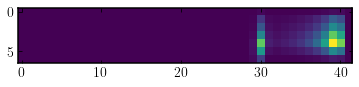

In [193]:
plt.imshow(pre_change_model.sfh.ceh.grid)
plt.show()
plt.imshow(post_change_model.sfh.ceh.grid)
plt.show()
plt.imshow(twostep_exp_model.sfh.ceh.grid)
plt.show()

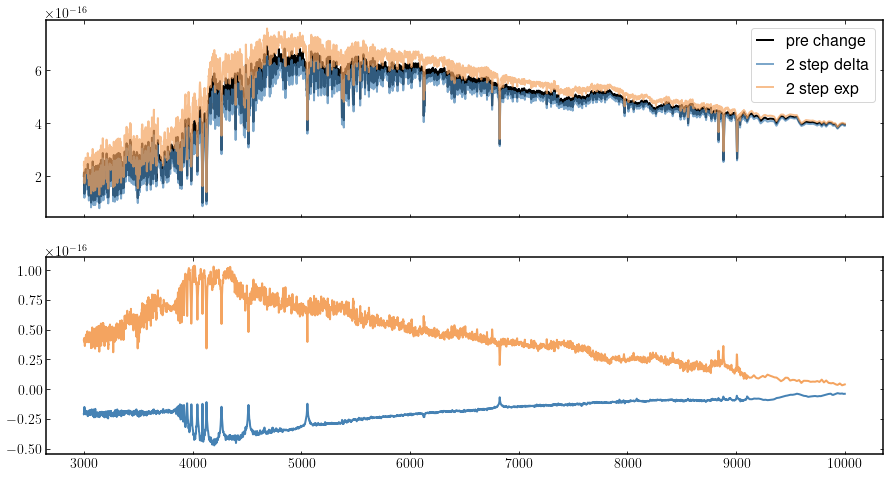

In [196]:
fig, ax = plt.subplots(2,1, figsize=[15,8], sharex=True)
ax[0].plot(obs_wavs, pre_change_model.spectrum[:,1], label='pre change', color='black')
ax[0].plot(obs_wavs, post_change_model.spectrum[:,1], label='2 step delta', color='steelblue', alpha=0.7)
ax[0].plot(obs_wavs, twostep_exp_model.spectrum[:,1], label='2 step exp', color='sandybrown', alpha=0.7)
ax[0].legend()
ax[1].plot(obs_wavs, post_change_model.spectrum[:,1] - pre_change_model.spectrum[:,1], color='steelblue')
ax[1].plot(obs_wavs, twostep_exp_model.spectrum[:,1] - pre_change_model.spectrum[:,1], color='sandybrown')

plt.show()

## fitting this new model with bagpipes

In [197]:
def load_uds_spectrum_mask_generated_exp(ID,z):

    # load spectral data
    spectrum = twostep_exp_model.spectrum.copy()
    spectrum_noise = spectrum[:,1]/15
    spectrum = np.hstack([spectrum, np.expand_dims(spectrum_noise, axis=1)])

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum
    

def load_uds_mask_generated_exp(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask_generated_exp(ID,z)

    return spectrum

def get_fit_instructions_exp(z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb2 = {}
    psb2["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb2["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
    psb2["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
    psb2["metallicity_old"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
    psb2["metallicity_old_prior"] = "log_10"
    psb2["metallicity_burst"] = (0.01, 2.5)
    psb2["metallicity_burst_prior"] = "log_10"
    psb2["metallicity_scatter"] = "exponential"
    
    psb2["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
    psb2["alpha"] = (0.01,1000)               # decline of burst
    psb2["alpha_prior"] = "log_10"
    psb2["beta"] = 250.                    # rise of burst: fixed
    psb2["fburst"] = (0,1)
    
    fit_instructions = {}
    fit_instructions['psb_wild2020'] = psb2
    fit_instructions['redshift'] = (z-0.2*z, z+0.2*z)
    
    return fit_instructions

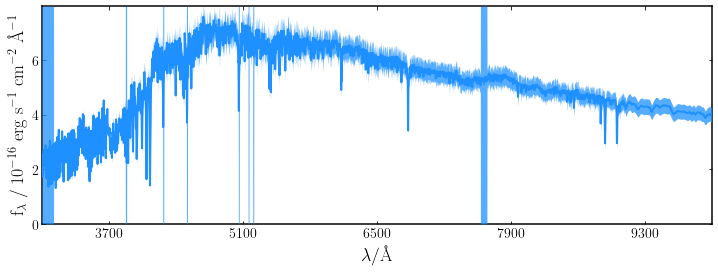

In [198]:
ID = 'two_step_exp_metallicity_generated_psb_no_dust_no_noise_SNR15_recovary_test'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask_generated_exp, photometry_exists=False)

fig = galaxy.plot()

In [199]:
fit_instructions = get_fit_instructions_exp()
print(fit_instructions)

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10', 'metallicity_scatter': 'exponential', 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [201]:
pipes.config.Rspec = 4340
runID = "two_step_exp_metallicity_generated_psb_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object two_step_exp_metallicity_generated_psb_no_dust_no_noise_SNR15_recovary_test


Completed in 11130.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               8.306      9.995     11.728
psb_wild2020:alpha           180.121    388.022    713.485
psb_wild2020:burstage          0.964      1.024      1.080
psb_wild2020:fburst            0.182      0.209      0.248
psb_wild2020:massformed        9.950      9.984     10.013
psb_wild2020:metallicity_burst      1.373      1.734      2.159
psb_wild2020:metallicity_old      0.963      1.075      1.194
psb_wild2020:tau               4.113      6.596      8.887
redshift                       0.040      0.040      0.040




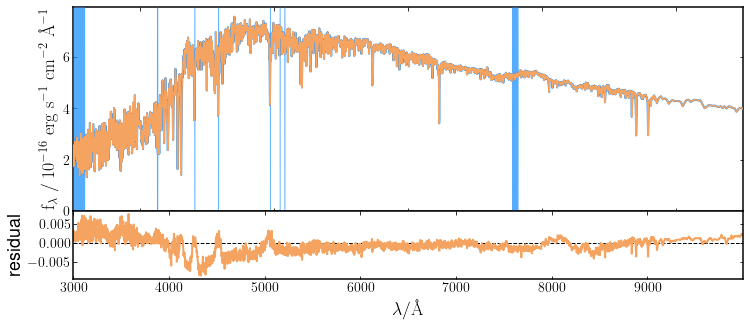

only recovered 0.838858767003315 of total mass formed.
9.923690646638525 10.000001798889988
model f_burst and t_burst: 0.2 11.924065623716086
model f_burst and t_burst: 0.2 11.924065623716086
posterior f_burst and t_burst: [0.18269744 0.20990143 0.24311514] [11.84966969 11.90068726 11.95481286]


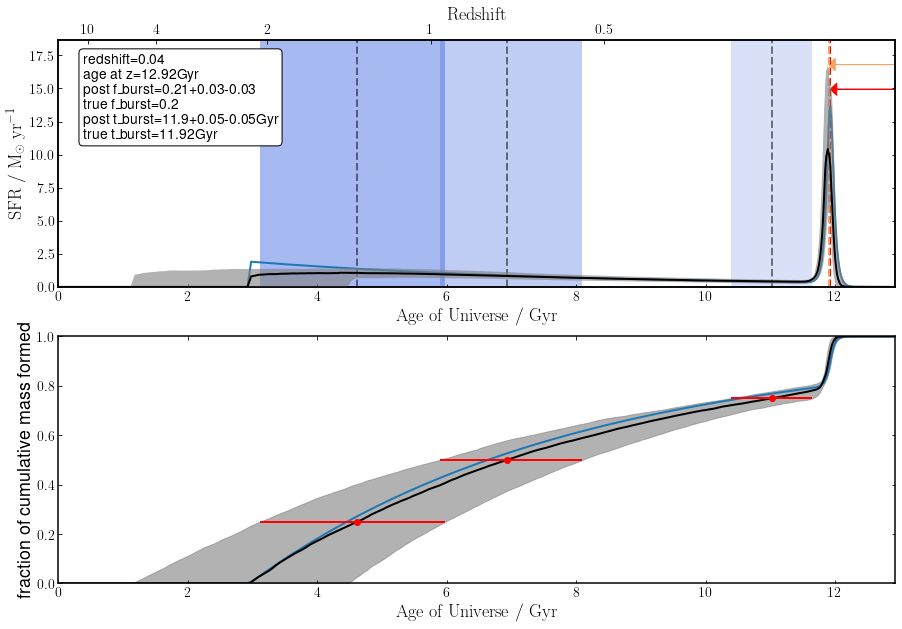

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [205]:
plot_spec(fit, ID, runID)
fig = fit.plot_corner(save=True, show=True)
plot_sfh(fit, twostep_exp_model.sfh.ages*10**-9, twostep_exp_model.sfh.sfh, ID, runID, 
        model_f_burst=model_components2['psb_wild2020']['fburst'],
        model_burstage=model_components2['psb_wild2020']['burstage'])

Looks great, now trying it on Yirui's simulation

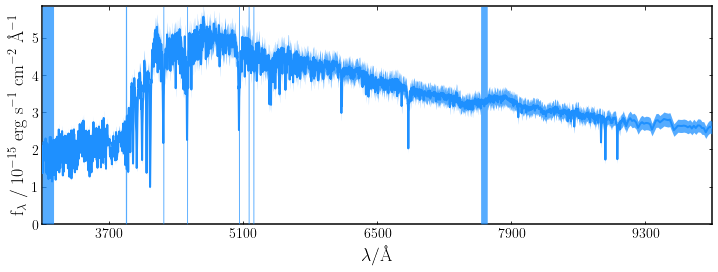

In [207]:
ID = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fig = galaxy.plot()

In [208]:
fit_instructions = get_fit_instructions_exp()
print(fit_instructions)

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10', 'metallicity_scatter': 'exponential', 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [209]:
pipes.config.Rspec = 4340
runID = "two_step_exp_metallicity_yirui_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object 2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test


Completed in 8525.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age              11.538     12.290     12.769
psb_wild2020:alpha           495.078    709.368    901.190
psb_wild2020:burstage          0.599      0.620      0.638
psb_wild2020:fburst            0.157      0.165      0.175
psb_wild2020:massformed       10.901     10.934     10.957
psb_wild2020:metallicity_burst      2.366      2.450      2.488
psb_wild2020:metallicity_old      2.453      2.481      2.495
psb_wild2020:tau               0.554      1.099      1.946
redshift                       0.040      0.040      0.040




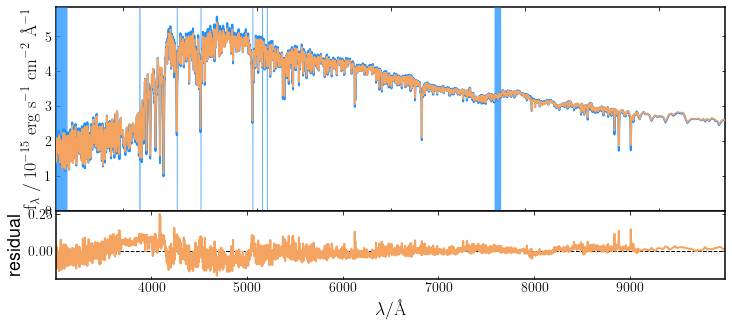

only recovered 0.6090051260162332 of total mass formed.
10.81102312826174 11.026402180142501
model f_burst and t_burst: 0.08993122012854099 12.374083527325773
model f_burst and t_burst: 0.08993122012854099 12.374083527325773
posterior f_burst and t_burst: [0.15613008 0.16489494 0.17396349] [12.28406261 12.30348578 12.32500204]


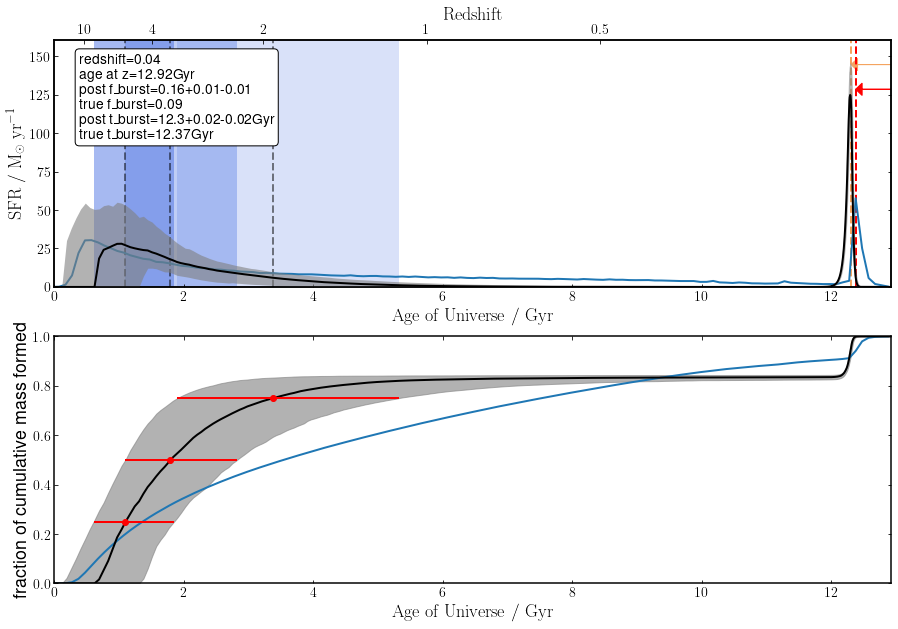

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [210]:
plot_spec(fit, ID, runID)
fig = fit.plot_corner(save=True, show=True)
plot_sfh(fit, model_ages, model_sfh, ID, runID)